In [1]:
# Run eight schools
# again, this only works on startup!
import os
from functools import partial

import equinox as eqx
import jax.random as jr
import jaxtyping
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from numpyro import handlers
from numpyro.infer import Predictive

with jaxtyping.install_import_hook(["cnpe", "cnpe_validation"], "beartype.beartype"):
    from cnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
    from cnpe.numpyro_utils import get_sample_site_names
    from cnpe.train import train

    from cnpe_validation.tasks.eight_schools import EightSchoolsTask
    from cnpe_validation.tasks.tasks import AbstractTaskWithReference
    from cnpe_validation.utils import get_abspath_project_root
    

os.chdir(get_abspath_project_root())

In [2]:
seed = 2
maximum_likelihood_steps = 4000
contrastive_steps = 1000
num_contrastive = 20

key, subkey = jr.split(jr.PRNGKey(seed))
task = EightSchoolsTask(subkey)

key, subkey = jr.split(key)
obs, true_latents = task.get_observed_and_latents_and_check(subkey)

posteriors = {}
losses = {}

key, subkey = jr.split(key)

# Pretrain using amortized maximum likelihood
loss = AmortizedMaximumLikelihood(task.model.reparam())

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.adam(optax.linear_schedule(1e-3, 1e-5, maximum_likelihood_steps)),
        optax.clip_by_global_norm(5),
    ),
    max_consecutive_errors=100,
)
method_name = "maximum likelihood"
key, subkey = jr.split(key)
posteriors[method_name], losses[method_name] = train(
    subkey,
    guide=task.guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)


optimizer = optax.apply_if_finite(
    optax.chain(
        optax.adam(optax.linear_schedule(1e-3, 1e-4, maximum_likelihood_steps)),
        optax.clip_by_global_norm(5),
    ),
    max_consecutive_errors=100,
)

# Fine tune with contrastive loss
for stop_grad in [False, True]:
    method_name = f"contrastive (stop grad={stop_grad})"

    loss = ContrastiveLoss(
        model=task.model.reparam(),
        obs=obs,
        n_contrastive=num_contrastive,
        stop_grad_for_contrastive_sampling=stop_grad,
    )

    key, subkey = jr.split(key)

    posteriors[method_name], losses[method_name] = train(
        subkey,
        guide=posteriors["maximum likelihood"],
        loss_fn=loss,
        steps=contrastive_steps,
        optimizer=optimizer,
    )


100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s, loss=15.1]


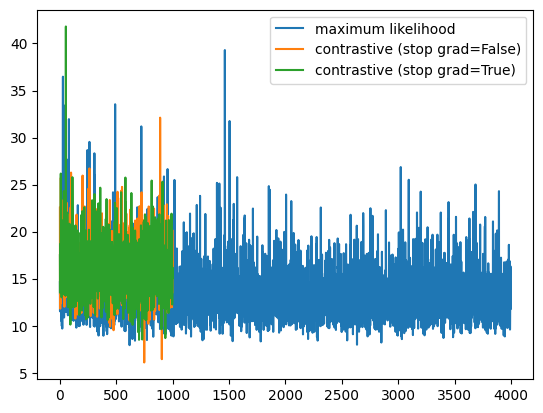

In [3]:
for method_name, v in losses.items():
    plt.plot(v, label=method_name)
plt.legend()

In [4]:

def compute_true_latent_prob(true_latents, posteriors, model, obs):  # For a single latent
    log_probs = {
        k: posterior.log_prob_original_space(
            latents=true_latents,
            model=model,
            obs=obs,
        )
        for k, posterior in posteriors.items()
    }
    log_probs["prior"] = model.reparam(set_val=False).prior_log_prob(true_latents)
    return log_probs

compute_true_latent_prob = partial(
    compute_true_latent_prob,
    posteriors=posteriors,
    model=task.model,
    obs=obs,
    )

if isinstance(task, AbstractTaskWithReference):  # Batch of "true" samples
    compute_true_latent_prob = eqx.filter_vmap(compute_true_latent_prob)

log_prob_true = compute_true_latent_prob(true_latents)


([0, 1, 2, 3],
 [Text(0, 0, 'contrastive (stop grad=False)'),
  Text(1, 0, 'contrastive (stop grad=True)'),
  Text(2, 0, 'maximum likelihood'),
  Text(3, 0, 'prior')])

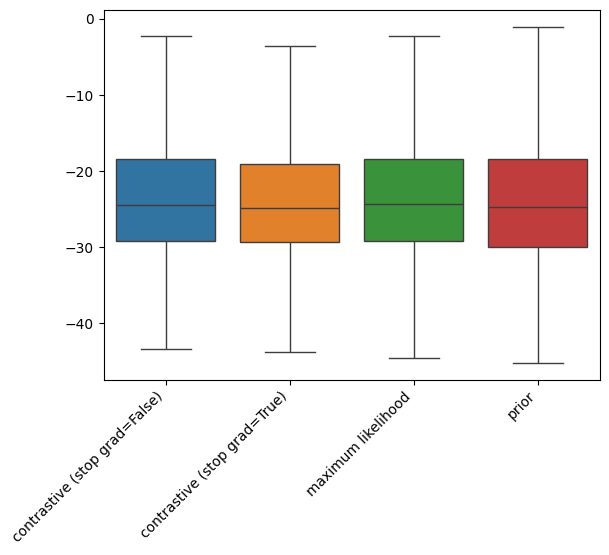

In [5]:
sns.boxplot(pd.DataFrame(log_prob_true), showfliers="")
plt.xticks(rotation=45, ha='right')

In [6]:
for k, v in log_prob_true.items():
    print(f"{k} log prob mean: {v.mean()}")

contrastive (stop grad=False) log prob mean: -22.87915802001953
contrastive (stop grad=True) log prob mean: -23.230627059936523
maximum likelihood log prob mean: -22.805530548095703
prior log prob mean: -23.249759674072266


In [7]:
key, subkey = jr.split(key)

posterior_samples = {}

for k, posterior in posteriors.items():
    posterior_samples[k] = Predictive(
        posterior,
        num_samples=5000,
        )(key, obs=obs)

# We have to trace the model to avoid the reparamterization

def to_original_space(posterior_samples, model, *args, **kwargs):
    # TODO move into guide class
    posterior_samples = {k: v for k, v in posterior_samples.items()} # Avoid mutating
    trace = handlers.trace(
        handlers.condition(model, posterior_samples),
        ).get_trace(*args, **kwargs)
    
    for name in model.reparam_names:
        posterior_samples.pop(f"{name}_base")
        posterior_samples[name] = trace[name]["value"]

    return posterior_samples


posterior_samples = {k: eqx.filter_vmap(
    partial(to_original_space, model=task.model, obs=obs))(samps)
    for k, samps in posterior_samples.items()
}


ValueError: Reparameterized flag was None. Set to True/False using model.reparam.

In [ ]:
key, subkey = jr.split(key)
prior_samples = Predictive(task.model.call_without_reparam, num_samples=5000)(key)
[prior_samples.pop(name) for name in task.model.observed_names]
latent_names = get_sample_site_names(task.model.call_without_reparam, obs=obs).latent

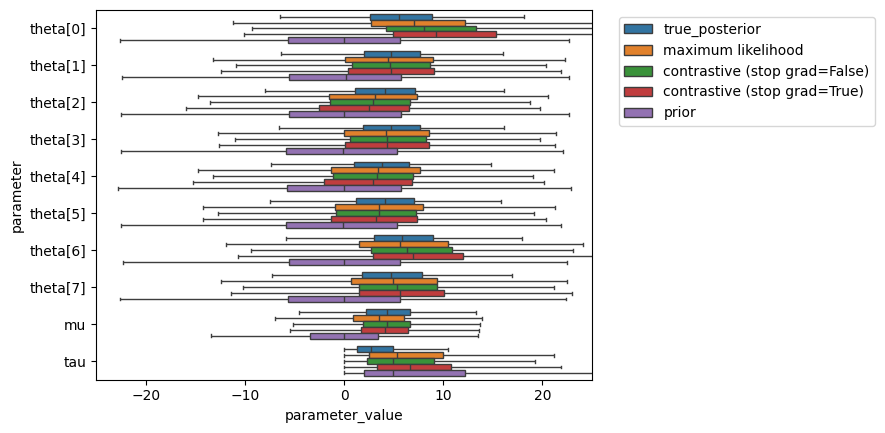

In [ ]:

samples = {
    "true_posterior": true_latents,
} | posterior_samples | {"prior": prior_samples}

dfs = []
for k, samps in samples.items():
    columns = {}
    for name, arr in samps.items():
        if arr.ndim == 1:
            columns[name] = arr
        
        if arr.ndim == 2:
            for i in range(arr.shape[-1]):
                columns[f"{name}[{i}]"] = arr[:, i]
    df = pd.DataFrame(columns)
    df["source"] = k
    dfs.append(df)

df = pd.concat(dfs)
df = df.melt(id_vars="source", var_name="parameter", value_name="parameter_value")
sns.boxplot(data=df, x="parameter_value", y="parameter", hue="source", showfliers="")
plt.xlim(-25, 25)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")